# The Objects Lab

###   `__repr__`  vs  `__str__`

The way printing works is that Python wants classes to implement a `__repr__` and a `__str__` method. It will use inheritance to give the built-in `object`'s methods when these are not defined...but any class can define these. When an *instance* of such a class is interrogated with the `repr` or `str` function, then these underlying methods are called.

Rules used (see http://stackoverflow.com/questions/1436703/difference-between-str-and-repr-in-python):

- if you override `__repr__`, that's ALSO used for `__str__`, but not vice versa
- `__str__` on a built-on container uses the contained objects `__repr__`

Some advice on thisI found useful:

- From Alex Martelli: 
>So, my advice: focus on making __str__ reasonably human-readable, and __repr__ as unambiguous as you possibly can.

From SO:
>This means, in simple terms: almost every object you implement should have a functional __repr__ that’s usable for understanding the object. Implementing __str__ is optional: do that if you need a “pretty print” functionality

Usually people will have the repr print out a constructor form. Ned Batchelder:
>My rule of thumb:  __repr__ is for developers, __str__ is for customers.



### 1. `__str__`

Implement `__str__` for `class Animal` below to simply print "Animal Jane" for an Animal with name Jane. Keep your code as general as possible.

In [1]:
class Animal():
    
    def __init__(self, name):
        self.name=name

    def __repr__(self):
        class_name = type(self).__name__
        return "%s(name=%r)" % (class_name, self.name)
    
    #your code here
    def __str__(self):
        class_name = type(self).__name__
        return "%s %s" % (class_name,self.name)


In [2]:
A=Animal("Tom")
B=Animal("Jane")

In [3]:
B#the ipython REPL uses __repr__ even if __str__ is defined

Animal(name='Jane')

In [4]:
print(B)#printing uses __str__

Animal Jane


In [5]:
print(str(B)) # uses __str__
print(repr(B)) # uses __repr__

Animal Jane
Animal(name='Jane')


Notice that printing things in a list uses the item's `__repr__`:

In [6]:
print([A, B])

[Animal(name='Tom'), Animal(name='Jane')]


In [7]:
import reprlib #reprlib.repr provides small size representations of object strings

In [8]:
reprlib.repr([A]*50)

"[Animal(name='Tom'), Animal(name='Tom'), Animal(name='Tom'), Animal(name='Tom'), Animal(name='Tom'), Animal(name='Tom'), ...]"

### Properties, Descriptors, and Setters

Our earlier `ComplexClass` gave direct access to both the `real` and `imaginary` parts of the complex number. But lets say we wanted to build a strange complex number which did not allow you to change the imaginary part of a complex number. We then use properties to "encapsulate" the actual values of the complex number. There is a `@property` decorator that does this for us. Its actually instantiates a class for us which is something called a `descriptor`, but that too is a story for later. Currently we just treat it as a black box.

In [9]:
class ComplexClass():
    
    def __init__(self, a, b):
        self.__real = a
        self.__imaginary = b
    
    def __repr__(self):
        class_name = type(self).__name__
        return "%s(real=%r, imaginary=%r)" % (class_name, self.__real, self.__imaginary)
        
    @property
    def real(self):
        return self.__real
    
    @real.setter
    def real(self, value=None):
        if value:
            self.__real=value
            
    @property
    def imaginary(self):
        return self.__imaginary
    

In [10]:
c1 = ComplexClass(1,2)
c1.real, c1.imaginary

(1, 2)

Notice that I can change the value of the real part and make it read-only

In [11]:
c1.real = 5

But I cannot change the value of the imaginary part

In [12]:
c1.imaginary = 3

AttributeError: can't set attribute

### Q2. Add a class method

Implement a class method `make_complex` that takes two arguments and constructs a complex number for us. Rewrite the class definition above with this method.

Also add a `__str__` method to print out complex numbers in the usual form `1+2i`.

Test (informally) that both your methods work.

In [13]:
class ComplexClass():
    
    def __init__(self, a, b):
        self.__real = a
        self.__imaginary = b
    
    def __repr__(self):
        class_name = type(self).__name__
        return "%s(real=%r, imaginary=%r)" % (class_name, self.__real, self.__imaginary)
    
    def __str__(self):
        if self.__imaginary >= 0:
            return '{} + {}i'.format(self.__real, self.__imaginary)
        if self.__imaginary < 0:
            return '{} - {}i'.format(self.__real, abs(self.__imaginary))
        
    @property
    def real(self):
        return self.__real
    
    @real.setter
    def real(self, value=None):
        if value:
            self.__real=value
            
    @property
    def imaginary(self):
        return self.__imaginary
    
    @classmethod
    def make_complex(cls,x,y):
        # create a complex number 
        return cls(x,y)

In [14]:
# your code here
c1 = ComplexClass(1,-2)
print(c1)

1 - 2i


In [15]:
# your code here
c2 = ComplexClass.make_complex(1,2)
print(c2)

1 + 2i


Notice that python marginally obfuscates variables with two leading underscores. But where are our properties?

In [16]:
vars(c1)

{'_ComplexClass__imaginary': -2, '_ComplexClass__real': 1}

This tells us a bit about lookup with properties. When you do instance.attribute for something marked as a property, it is first looked up in instance.__class__ and only then in the instance specific dictionary. 

In [17]:
vars(type(c1))

mappingproxy({'imaginary': <property object at 0x104221f98>, '__init__': <function ComplexClass.__init__ at 0x104225488>, 'make_complex': <classmethod object at 0x10429b550>, '__dict__': <attribute '__dict__' of 'ComplexClass' objects>, '__repr__': <function ComplexClass.__repr__ at 0x104225510>, '__doc__': None, '__weakref__': <attribute '__weakref__' of 'ComplexClass' objects>, 'real': <property object at 0x1042219a8>, '__module__': '__main__', '__str__': <function ComplexClass.__str__ at 0x104225598>})

The usual way in Python is exactly the reverse, a variable called as `self.x` is first looked up in the instance dictionary, and only then in the class dictionary.

### A sequence for light curves

In [18]:
!head -5 ./data/CEPH/lc_1.3441.15.B.mjd

#Field Tile Seq RA(hour) Dec(deg) Filter mean_Mag med_Mag mean_(B-R) med_(B-R)
#1 3441 15 5.03111 -69.3896 B -9.765 -9.748 0.219 0.243
#MJD Mag Err
48823.477419 -9.332 0.012
48823.487014 -9.396 0.01


In [19]:
def lc_reader(filename):
    lclist=[]
    with open(filename) as fp:
        for line in fp:
            if line.find('#')!=0:
                lclist.append([float(f) for f in line.strip().split()])
    return lclist
                

In [20]:
eg = lc_reader("./data/CEPH/lc_1.3441.15.B.mjd")
eg[:5]

[[48823.477419, -9.332, 0.012],
 [48823.487014, -9.396, 0.01],
 [48823.496759, -9.358, 0.011],
 [48824.458206, -9.333, 0.003],
 [48824.467697, -9.333, 0.003]]

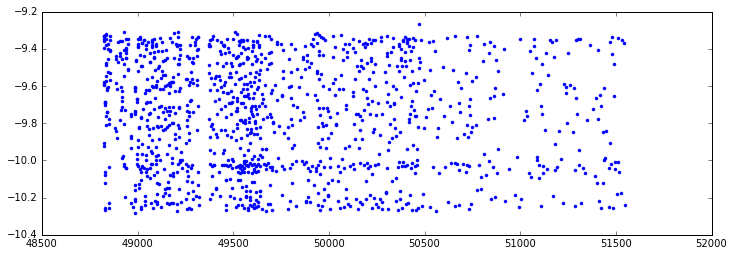

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot([x[0] for x in eg], [x[1] for x in eg],'.');

### Q3. Reader with metadata

The first two lines of the file, after the `#` have facet names and facet values. These are in the same order and space separated. Change `lc_reader` ro parse these lines as well, returning both the list we had earlier, and a second dictionary of facetnames and facetvalues.

In [22]:
# your code here
eg


[[48823.477419, -9.332, 0.012],
 [48823.487014, -9.396, 0.01],
 [48823.496759, -9.358, 0.011],
 [48824.458206, -9.333, 0.003],
 [48824.467697, -9.333, 0.003],
 [48824.477639, -9.349, 0.003],
 [48825.483183, -9.588, 0.002],
 [48825.492847, -9.592, 0.002],
 [48825.502824, -9.581, 0.002],
 [48826.46463, -9.908, 0.003],
 [48826.491319, -9.921, 0.003],
 [48828.585961, -10.257, 0.002],
 [48828.656701, -10.266, 0.002],
 [48829.456285, -10.119, 0.001],
 [48829.584769, -10.08, 0.003],
 [48829.659965, -10.061, 0.002],
 [48831.461817, -9.684, 0.013],
 [48831.564722, -9.684, 0.004],
 [48831.63897, -9.703, 0.001],
 [48831.661551, -9.691, 0.003],
 [48832.459769, -9.575, 0.003],
 [48832.65125, -9.546, 0.003],
 [48833.569375, -9.378, 0.007],
 [48834.430926, -9.324, 0.003],
 [48834.515544, -9.318, 0.002],
 [48834.639225, -9.346, 0.002],
 [48835.571053, -9.476, 0.005],
 [48835.606296, -9.489, 0.004],
 [48836.522002, -9.763, 0.009],
 [48836.564236, -9.812, 0.005],
 [48841.441516, -9.742, 0.004],
 [48841.

We use your definition above to write a `LightCurve` class with a class method that reads the light curve from a file. 

### Q4. A Light Curve Class with properties

Since data in a light-curve is read-once, we use properties to prevent any changes to the data. Add to the light curve class below read-only properties `time`, `amplitude` which correspond to `_time` and `_amplitude`, and also a read-only property `timeseries` which zips these together. Notice how `self.timeseries` is used in `__repr__` below. 

In [42]:
import itertools
class LightCurve:
    
    def __init__(self, data, metadict):
        self._time = [x[0] for x in data]
        self._amplitude = [x[1] for x in data]
        self._error = [x[2] for x in data]
        self.metadata = metadict
        self.filename = None
    
    @classmethod
    def from_file(cls, filename):
        lclist, metadict = lc_reader(filename)
        instance = cls(lclist, metadict)
        instance.filename = filename
        return instance
    
    def __repr__(self):
        class_name = type(self).__name__
        components = reprlib.repr(list(itertools.islice(self.timeseries,0,10)))
        components = components[components.find('['):]
        return '{}({})'.format(class_name, components)        
        
    #your code here


In [43]:
l = LightCurve.from_file("./data/CEPH/lc_1.3441.15.B.mjd")
l

### Q5. Make LightCurve a sequence

But our Lightcurves class is not a sequence yet! It implements none of the sequence protocol. The `__repr__` above makes it look like one, but its your job to make it one! (Hint: dont change the O-complexity behavior of indexing)

In [119]:
#your code here


In [120]:
l2 = LightCurve.from_file("./data/CEPH/lc_1.3441.15.B.mjd")
l2

In [121]:
len(l2)

In [122]:
l2[100]

In [123]:
l2[1:3]# this will be not quite what we want given our __repr__

The reason for the above not being quite the result we expect is because we dont yet know how Python handles slices. We shall do this next week!

### A database for light curves

We now write a small little database class whose game is to read all light curves from a directory, store them in memory and construct an "index" on the field, tile, and color that these light-curves have.

A light curve filename of the form `lc_1.3441.15.B.mjd` means that this data has `field` 1, `tile` 3441, `sequence` 15, and `color` 'B'. We'll parse the filenames below and store the indexed in internal attributes such as `self._field_index`. Note the use of `defaultdict` instead of a regular dictionary (look it up). Are we duplicating Light Curve objects in these indices?

### Q6. 

Write a method `def retrieve(self, facet, value)` which retrieves a list of Light Curves corresponding to the given value of the facet. (like say facet is tile and value is 4661).

In [85]:
import os
from collections import defaultdict
class LightCurveDB:
    
    def __init__(self):
        self._collection={}
        self._field_index=defaultdict(list)
        self._tile_index=defaultdict(list)
        self._color_index=defaultdict(list)
    
    def populate(self, folder):
        for root,dirs,files in os.walk(folder): # DEPTH 1 ONLY
            for file in files:
                if file.find('.mjd')!=-1:
                    the_path = root+"/"+file
                    self._collection[file] = LightCurve.from_file(the_path)
    
    def index(self):
        for f in self._collection:
            lc, tilestring, seq, color, _ = f.split('.')
            field = int(lc.split('_')[-1])
            tile = int(tilestring)
            self._field_index[field].append(self._collection[f])
            self._tile_index[tile].append(self._collection[f])
            self._color_index[color].append(self._collection[f])
     
    #your code here


In [86]:
ldb = LightCurveDB()
ldb.populate("./data/CEPH")
ldb.index()

In [89]:
ldb.retrieve('tile', 4661) # do this

### Q7. Module-arity

Put your `lc_reader`, and `LightCurve` and `LightCurveDB` classes in a module: a separate file, named lc.py. Organize the imports at the top. The following code should then work here

In [124]:
import lc
ldb2 = lc.LightCurveDB()
ldb2.populate("./data/CEPH")
ldb2.index()
ldb2.retrieve('tile', 4661)